In [365]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import glob

from scipy.interpolate import interp1d

In [390]:
env_name = 'Hopper'

file_list = glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}__sac_baseline__*/events.out.tfevents.*')
# HalfCheetah-v4__sac_icl_updatefreq1000_+25p_freq128_cl500_mode_error20perc_auxact__15037__1726427294
# if env_name=='Hopper':
#     file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq1000_+10p*__*/events.out.tfevents.*')
#     file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq1000_+5p*__*/events.out.tfevents.*')
#     file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq1000_+25p*__*/events.out.tfevents.*')
# elif env_name=='HalfCheetah':
#     # file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}-v4__sac_icl_updatefreq1000_+100p*__*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}-v4__sac_icl_updatefreq1000_+5p_freq256_cl500_mode_auxact__*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}-v4__sac_icl_updatefreq1000_+10p_freq256_cl500_mode_auxact__*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}-v4__sac_icl_updatefreq1000_+25p_freq256_cl500_mode_auxact__*/events.out.tfevents.*')

max_steps = int(1e5)
moving_average_window = 100

data_frames = []
interp_data_frames = []
moving_average_data_frames = []
for file in file_list:
    print(file)
    # Load the event file
    # log_dir = '/mnt/vdb/abenechehab/cleanrl/runs/Ant__sac_baseline__19945__1726244636/events.out.tfevents.1726244636.autodsgpularge1.3644404.0'
    event_acc = tf.compat.v1.train.summary_iterator(file)
    
    # Extract data
    steps = []
    values = []
    for e in event_acc:
        for v in e.summary.value:
            if v.tag == 'charts/episodic_return':
                steps.append(e.step)
                values.append(v.simple_value)
                df = pd.DataFrame(np.concatenate([np.array(steps)[..., None], np.array(values)[..., None]], axis=1), columns=['Step', 'Value'])
                if int(np.max(df['Step'].values)) >= max_steps:
                    # Extract the algorithm variation from the filename
                    df['Variation'] = file.split('/')[-2].split('__')[1]
                    df['seed'] = file.split('/')[-2].split('__')[2]
                    df['Episode'] = np.arange(len(df))
                    # interpolation
                    f = interp1d(
                        x=np.concatenate([np.array([0]), df['Step'].values], axis=0), 
                        y=np.concatenate([np.array([0]), df['Value'].values], axis=0)
                    )
                    # all_steps = np.arange(1, int(np.max(df['Step'].values)), 100)
                    all_steps = np.arange(1, max_steps, 100)
                    all_returns = f(all_steps)
                    interp_df = pd.DataFrame(np.concatenate([all_steps[..., None], all_returns[..., None]], axis=1), columns=['Step', 'Value']) 
                    interp_df['Variation'] = file.split('/')[-2].split('__')[1]
                    interp_df['seed'] = file.split('/')[-2].split('__')[2]
                    data_frames.append(df)
                    interp_data_frames.append(interp_df)

                    # moving averages
                    smoothed = interp_df['Value'].rolling(window=moving_average_window).mean().to_numpy()[..., None]
                    mvav_df = pd.DataFrame(np.concatenate([all_steps[-len(smoothed):][..., None], smoothed], axis=1), columns=['Step', 'Value']) 
                    mvav_df['Variation'] = file.split('/')[-2].split('__')[1]
                    mvav_df['seed'] = file.split('/')[-2].split('__')[2]
                    moving_average_data_frames.append(mvav_df)
                    

# Concatenate all DataFrames
df_all = pd.concat(data_frames, ignore_index=True)
interp_df_all = pd.concat(interp_data_frames, ignore_index=True)
moving_average_df_all = pd.concat(moving_average_data_frames, ignore_index=True)

interp_df_all

/mnt/vdb/abenechehab/cleanrl/runs/Hopper__sac_baseline__13564__1726411302/events.out.tfevents.1726411302.autodsgpularge1.821396.0
/mnt/vdb/abenechehab/cleanrl/runs/Hopper__sac_baseline__12819__1726371392/events.out.tfevents.1726371392.autodsgpularge1.3934952.0
/mnt/vdb/abenechehab/cleanrl/runs/Hopper__sac_baseline__17799__1726429188/events.out.tfevents.1726429188.autodsgpularge1.857154.0
/mnt/vdb/abenechehab/cleanrl/runs/Hopper__sac_baseline__9996__1726392281/events.out.tfevents.1726392281.autodsgpularge1.777033.0
/mnt/vdb/abenechehab/cleanrl/runs/Hopper__sac_baseline__23560__1726350536/events.out.tfevents.1726350536.autodsgpularge1.3895757.0
/mnt/vdb/abenechehab/cleanrl/runs/Hopper-v4__sac_icl_updatefreq1000_+5p_freq256_cl500_mode_auxact__17597__1727644531/events.out.tfevents.1727644531.autods.2453199.0
/mnt/vdb/abenechehab/cleanrl/runs/Hopper-v4__sac_icl_updatefreq1000_+5p_freq256_cl500_mode_auxact__11438__1727644258/events.out.tfevents.1727644258.autodsgpularge1.1055909.0
/mnt/vdb/a

,Step,Value,Variation,seed
0,1.0,0.610529,sac_baseline,13564
1,101.0,12.719061,sac_baseline,13564
2,201.0,31.973280,sac_baseline,13564
3,301.0,11.316241,sac_baseline,13564
4,401.0,12.787603,sac_baseline,13564
...,...,...,...,...
42137995,99501.0,618.910369,sac_icl_updatefreq1000_+25p_freq256_cl500_mode...,7239
42137996,99601.0,635.498977,sac_icl_updatefreq1000_+25p_freq256_cl500_mode...,7239
42137997,99701.0,554.892346,sac_icl_updatefreq1000_+25p_freq256_cl500_mode...,7239
42137998,99801.0,535.798208,sac_icl_updatefreq1000_+25p_freq256_cl500_mode...,7239


n_seeds: 5
n_seeds: 5
n_seeds: 5
n_seeds: 5


<Figure size 640x480 with 0 Axes>

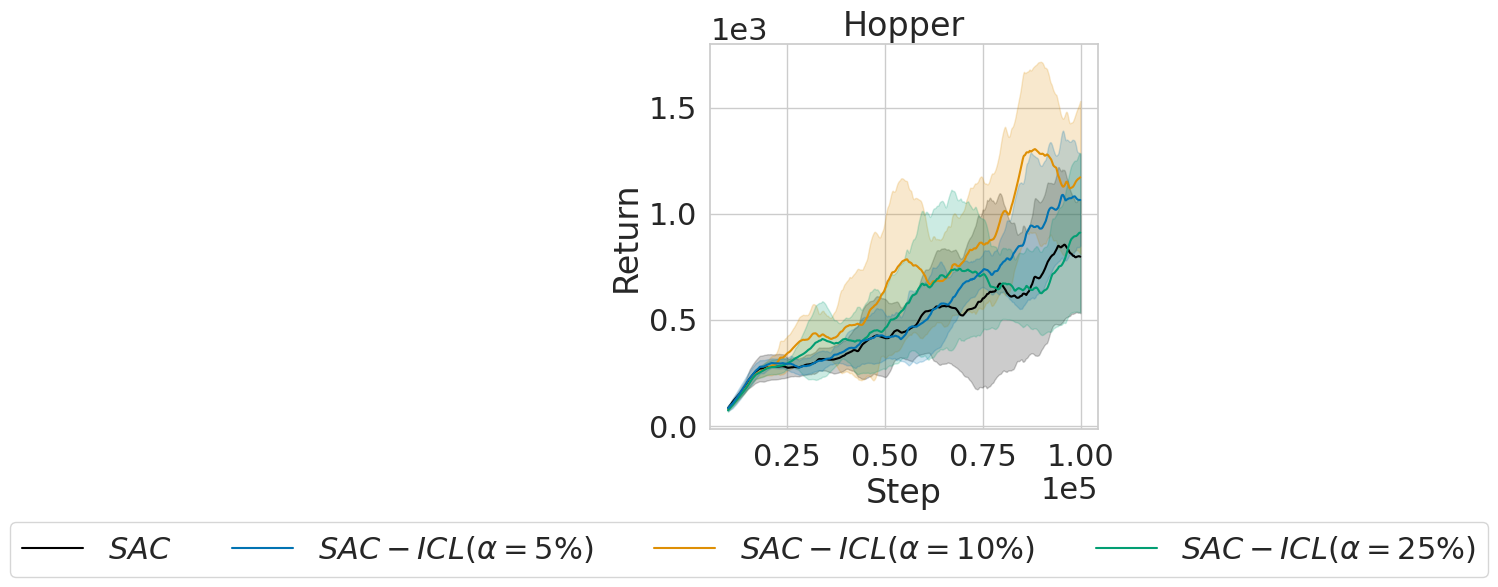

In [392]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

# Group by variation and step, then calculate mean and std
# grouped = interp_df_all.groupby(['Variation', 'Step'])['Value'].agg(['mean', 'std']).reset_index()
grouped = moving_average_df_all.groupby(['Variation', 'Step'])['Value'].agg(['mean', 'std']).reset_index()
# Plot the performance curves with mean and std
plt.figure(figsize=(5, 5))
colors = plt.get_cmap('tab10', 8)  # Use a color map

variations = grouped['Variation'].unique()
for i, variation in enumerate(variations):
    variation_data = grouped[grouped['Variation'] == variation]

    if '+' in variation:
        label = variation.split('_')[3]
    else:
        label = 'sac'
    n_seeds = len(moving_average_df_all.loc[moving_average_df_all['Variation'] == variation]['seed'].unique())
    print(f"n_seeds: {n_seeds}")
    if '+5' in variation:
        color = sns.color_palette("colorblind")[0]
        new_label = r'$SAC-ICL(\alpha=5\%)$'
    elif '+10' in variation:
        color = sns.color_palette("colorblind")[1]
        new_label = r'$SAC-ICL(\alpha=10\%)$'
    elif '+25' in variation:
        color = sns.color_palette("colorblind")[2]
        new_label = r'$SAC-ICL(\alpha=25\%)$'
    elif 'baseline' in variation:
        color = 'black'
        new_label = r'$SAC$'
        
    plt.plot(variation_data['Step'][:max_steps], variation_data['mean'][:max_steps], alpha=1., color=color, label=new_label)
    plt.fill_between(
        variation_data['Step'][:max_steps],
        variation_data['mean'][:max_steps] - 1.96*variation_data['std'][:max_steps]/np.sqrt(n_seeds),
        variation_data['mean'][:max_steps] + 1.96*variation_data['std'][:max_steps]/np.sqrt(n_seeds),
        alpha=0.2,
        color=color
    )
    # smoothed_mean = variation_data['mean'].rolling(window=100).mean()
    # plt.plot(variation_data['Step'][:max_steps], smoothed_mean[:max_steps], linestyle='--', color=colors(i), label=label)

plt.xlabel('Step')
plt.ylabel('Return')
plt.title(f'{env_name}')
plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.2))
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.1, -0.2), ncol=4)
# plt.legend()
# plt.grid(True)
plt.ticklabel_format(style='scientific', scilimits=(0,0))
# plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}_{max_steps}.pdf', bbox_inches='tight')
# plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}_{max_steps}.png', bbox_inches='tight')
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}_{max_steps}_legend.svg', bbox_inches='tight')
plt.show()

# MBRL

In [236]:
# file_list = glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/baseline_*/events.out.tfevents.*')
# HalfCheetah-v4__sac_icl_updatefreq1000_+25p_freq128_cl500_mode_error20perc_auxact__15037__1726427294
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/icl_best20_*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/icl_burnin_100_*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep2_*/events.out.tfevents.*')
file_list = glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/repeat_*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}-v4__sac_icl_updatefreq1000_+100p*__*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/baseline_250epochs*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/repeat_same_ep_5_50epochs*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/mbrl/baseline_50epochs*/events.out.tfevents.*')

max_steps = int(2e3)

data_frames = []
interp_data_frames = []
for file in file_list:
    print(file)
    # Load the event file
    # log_dir = '/mnt/vdb/abenechehab/cleanrl/runs/Ant__sac_baseline__19945__1726244636/events.out.tfevents.1726244636.autodsgpularge1.3644404.0'
    event_acc = tf.compat.v1.train.summary_iterator(file)
    
    # Extract data
    steps = []
    values = []
    for e in event_acc:
        for v in e.summary.value:
            if v.tag == 'Mean Episodic Return':
                steps.append(e.step)
                values.append(v.simple_value)
                df = pd.DataFrame(np.concatenate([np.array(steps)[..., None], np.array(values)[..., None]], axis=1), columns=['Step', 'Value'])
                if int(np.max(df['Step'].values)) >= max_steps:
                    # Extract the algorithm variation from the filename
                    df['Variation'] = file.split('/')[-2].split('__')[0]
                    df['seed'] = file.split('/')[-2].split('__')[1]
                    df['Episode'] = np.arange(len(df))
                    # interpolation
                    f = interp1d(
                        x=np.concatenate([np.array([0]), df['Step'].values], axis=0), 
                        y=np.concatenate([np.array([0]), df['Value'].values], axis=0)
                    )
                    # all_steps = np.arange(1, int(np.max(df['Step'].values)), 100)
                    all_steps = np.arange(1, max_steps, 100)
                    all_returns = f(all_steps)
                    interp_df = pd.DataFrame(np.concatenate([all_steps[..., None], all_returns[..., None]], axis=1), columns=['Step', 'Value']) 
                    interp_df['Variation'] = file.split('/')[-2].split('__')[0]
                    interp_df['seed'] = file.split('/')[-2].split('__')[1]
                    data_frames.append(df)
                    interp_data_frames.append(interp_df)

# Concatenate all DataFrames
df_all = pd.concat(data_frames, ignore_index=True)
interp_df_all = pd.concat(interp_data_frames, ignore_index=True)
interp_df_all

/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__7405__1727336172/events.out.tfevents.1727336174.autodsgpularge1.281101.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__30743__1727344185/events.out.tfevents.1727344186.autodsgpularge1.462984.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__25256__1727258014/events.out.tfevents.1727258016.autodsgpularge1.3506568.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__25245__1727345454/events.out.tfevents.1727345455.autodsgpularge1.493071.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__2572__1727311682/events.out.tfevents.1727311684.autodsgpularge1.4108488.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__24198__1727346142/events.out.tfevents.1727346144.autodsgpularge1.507205.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__12350__1727344770/events.out.tfevents.1727344772.autodsgpularge1.475897.0
/mnt/vdb/abenechehab/cleanrl/runs/mbrl/oracle_ep5__28707__1727322682/events.out.tfevents.1727322684.autodsgpularge1.91390.0
/

,Step,Value,Variation,seed
0,1.0,0.175185,oracle_ep5,7405
1,101.0,0.449867,oracle_ep5,7405
2,201.0,0.723236,oracle_ep5,7405
3,301.0,0.866507,oracle_ep5,7405
4,401.0,1.009666,oracle_ep5,7405
...,...,...,...,...
5575,1501.0,0.992807,baseline_50epochs,25916
5576,1601.0,1.019262,baseline_50epochs,25916
5577,1701.0,1.044399,baseline_50epochs,25916
5578,1801.0,1.069750,baseline_50epochs,25916


<Figure size 640x480 with 0 Axes>

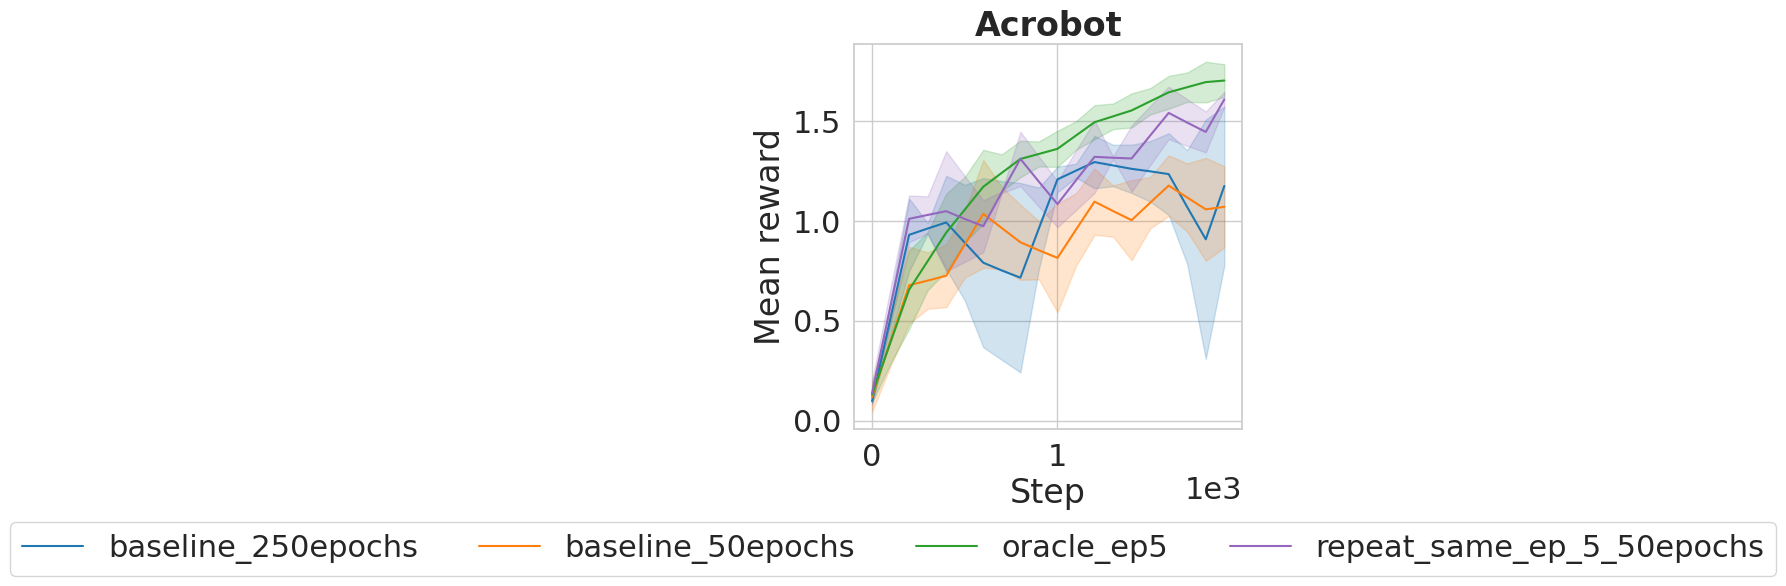

In [237]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

# Group by variation and step, then calculate mean and std
grouped = interp_df_all.groupby(['Variation', 'Step'])['Value'].agg(['mean', 'std']).reset_index()

# Plot the performance curves with mean and std
plt.figure(figsize=(5, 5))
colors = plt.get_cmap('tab10', 8)  # Use a color map

variations = grouped['Variation'].unique()
for i, variation in enumerate(variations):
    variation_data = grouped[grouped['Variation'] == variation]
    
    plt.plot(variation_data['Step'][:max_steps], variation_data['mean'][:max_steps], alpha=1.0, color=colors(i), label=variation)
    plt.fill_between(
        variation_data['Step'][:max_steps],
        variation_data['mean'][:max_steps] - variation_data['std'][:max_steps],
        variation_data['mean'][:max_steps] + variation_data['std'][:max_steps],
        alpha=0.2,
        color=colors(i)
    )
    # smoothed_mean = variation_data['mean'].rolling(window=100).mean()
    # plt.plot(variation_data['Step'][:max_steps], smoothed_mean[:max_steps], linestyle='--', color=colors(i), label=variation)

plt.xlabel('Step')
plt.ylabel('Mean reward')
plt.title('Acrobot', fontweight="bold")
plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.2), ncol=4)
# plt.legend()
# plt.grid(True)
plt.ticklabel_format(style='scientific', scilimits=(0,0))
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/mbrl_return_{env_name}.pdf', bbox_inches='tight')
plt.show()

# Pendulum

In [380]:
env_name = 'Pendulum'

# file_list = glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}__sac_baseline_startlearning1000_576batchsize_updatefreq1000__*/events.out.tfevents.*')
file_list = glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}__sac_baseline_startlearning1000__*/events.out.tfevents.*')
# HalfCheetah-v4__sac_icl_updatefreq1000_+25p_freq128_cl500_mode_error20perc_auxact__15037__1726427294
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq2000_+100p_freq16_cl198_mode_auxact_learningstarts1000_llmbatchsize512__*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq200_+100p_freq16_cl198_mode_auxact_learningstarts1000__*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq2000_+100p-pca_freq16_cl198_mode_learningstarts1000_llmbatchsize512__*/events.out.tfevents.*')
# Pendulum__sac_icl_updatefreq2000_+100p-pca_freq16_cl198_mode_learningstarts1000_llmbatchsize512__5602__1727447795
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq1000_+5p*__*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq1000_+25p*__*/events.out.tfevents.*')
# file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}-v4__sac_icl_updatefreq1000_+100p*__*/events.out.tfevents.*')
# sac_icl_updatefreq200_+100p_freq16_cl198_mode_auxact_learningstarts1000

file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq200_+10p_freq16_cl198_mode_auxact__*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq200_+25p_freq16_cl198_mode_auxact__*/events.out.tfevents.*')
file_list += glob.glob(f'/mnt/vdb/abenechehab/cleanrl/runs/{env_name}*__sac_icl_updatefreq200_+5p_freq16_cl198_mode_auxact__*/events.out.tfevents.*')


max_steps = int(1e4)
moving_average_window = 1

data_frames = []
interp_data_frames = []
moving_average_data_frames = []
for file in file_list:
    # Load the event file
    # log_dir = '/mnt/vdb/abenechehab/cleanrl/runs/Ant__sac_baseline__19945__1726244636/events.out.tfevents.1726244636.autodsgpularge1.3644404.0'
    event_acc = tf.compat.v1.train.summary_iterator(file)

    print_first = True
    
    # Extract data
    steps = []
    values = []
    for e in event_acc:
        for v in e.summary.value:
            if v.tag == 'charts/episodic_return':
                steps.append(e.step)
                values.append(v.simple_value)
                df = pd.DataFrame(np.concatenate([np.array(steps)[..., None], np.array(values)[..., None]], axis=1), columns=['Step', 'Value'])
                if int(np.max(df['Step'].values)) >= max_steps:
                    if print_first:
                        print(file)
                        print_first=False
                    # Extract the algorithm variation from the filename
                    df['Variation'] = file.split('/')[-2].split('__')[1]
                    df['seed'] = file.split('/')[-2].split('__')[2]
                    df['Episode'] = np.arange(len(df))
                    # interpolation
                    f = interp1d(
                        # x=np.concatenate([np.array([0]), df['Step'].values], axis=0),
                        x=df['Step'].values,
                        # y=np.concatenate([np.array([0]), df['Value'].values], axis=0),
                        y=df['Value'].values,
                    )
                    # all_steps = np.arange(1, int(np.max(df['Step'].values)), 100)
                    all_steps = np.arange(np.min(df['Step'].values), max_steps, 100)
                    all_returns = f(all_steps)
                    interp_df = pd.DataFrame(np.concatenate([all_steps[..., None], all_returns[..., None]], axis=1), columns=['Step', 'Value']) 
                    interp_df['Variation'] = file.split('/')[-2].split('__')[1]
                    interp_df['seed'] = file.split('/')[-2].split('__')[2]
                    data_frames.append(df)
                    interp_data_frames.append(interp_df)

                    # moving averages
                    smoothed = interp_df['Value'].rolling(window=moving_average_window).mean().to_numpy()[..., None]
                    mvav_df = pd.DataFrame(np.concatenate([all_steps[-len(smoothed):][..., None], smoothed], axis=1), columns=['Step', 'Value']) 
                    mvav_df['Variation'] = file.split('/')[-2].split('__')[1]
                    mvav_df['seed'] = file.split('/')[-2].split('__')[2]
                    moving_average_data_frames.append(mvav_df)
                    

# Concatenate all DataFrames
df_all = pd.concat(data_frames, ignore_index=True)
interp_df_all = pd.concat(interp_data_frames, ignore_index=True)
moving_average_df_all = pd.concat(moving_average_data_frames, ignore_index=True)

interp_df_all

/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__20347__1727391594/events.out.tfevents.1727391594.autodsgpularge1.37666.0
/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__12013__1727383715/events.out.tfevents.1727383715.autodsgpularge1.4177731.0
/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__25786__1727391587/events.out.tfevents.1727391587.autodsgpularge1.37524.0
/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__22473__1727385235/events.out.tfevents.1727385235.autodsgpularge1.4179407.0
/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__8138__1727390256/events.out.tfevents.1727390256.autodsgpularge1.17598.0
/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__29755__1727390281/events.out.tfevents.1727390281.autodsgpularge1.18125.0
/mnt/vdb/abenechehab/cleanrl/runs/Pendulum__sac_baseline_startlearning1000__6386__1727390275/events.out

,Step,Value,Variation,seed
0,200.0,-1050.557007,sac_baseline_startlearning1000,20347
1,300.0,-1048.547913,sac_baseline_startlearning1000,20347
2,400.0,-1046.538818,sac_baseline_startlearning1000,20347
3,500.0,-1112.463806,sac_baseline_startlearning1000,20347
4,600.0,-1178.388794,sac_baseline_startlearning1000,20347
...,...,...,...,...
78493,9500.0,-272.093925,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,1211
78494,9600.0,-241.455856,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,1211
78495,9700.0,-183.405121,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,1211
78496,9800.0,-125.354385,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,1211


n_seeds: 14
n_seeds: 27
n_seeds: 12
n_seeds: 10


<Figure size 640x480 with 0 Axes>

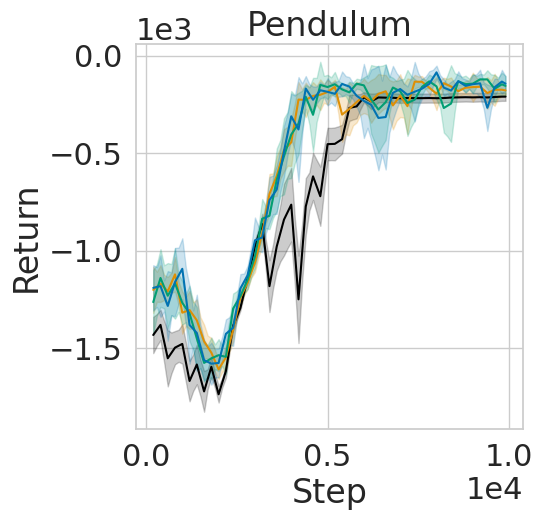

In [386]:
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

# Group by variation and step, then calculate mean and std
# grouped = interp_df_all.groupby(['Variation', 'Step'])['Value'].agg(['mean', 'std']).reset_index()
grouped = moving_average_df_all.groupby(['Variation', 'Step'])['Value'].agg(['mean', 'std']).reset_index()
# Plot the performance curves with mean and std
plt.figure(figsize=(5, 5))
colors = plt.get_cmap('tab10', 8)  # Use a color map

variations = grouped['Variation'].unique()
for i, variation in enumerate(variations):
    variation_data = grouped[grouped['Variation'] == variation]

    if '+' in variation:
        label = variation.split('_')[3]
    else:
        label = 'sac'
    n_seeds = len(moving_average_df_all.loc[moving_average_df_all['Variation'] == variation]['seed'].unique())
    print(f"n_seeds: {n_seeds}")
    if '+5' in variation:
        color = sns.color_palette("colorblind")[0]
    elif '+10' in variation:
        color = sns.color_palette("colorblind")[1]
    elif '+25' in variation:
        color = sns.color_palette("colorblind")[2]
    elif 'baseline' in variation:
        color = 'black'
    plt.plot(variation_data['Step'][:max_steps], variation_data['mean'][:max_steps], alpha=1., color=color, label=label)
    plt.fill_between(
        variation_data['Step'][:max_steps],
        variation_data['mean'][:max_steps] - 1.96*variation_data['std'][:max_steps]/np.sqrt(n_seeds),
        variation_data['mean'][:max_steps] + 1.96*variation_data['std'][:max_steps]/np.sqrt(n_seeds),
        alpha=0.2,
        color=color
    )
    # smoothed_mean = variation_data['mean'].rolling(window=100).mean()
    # plt.plot(variation_data['Step'][:max_steps], smoothed_mean[:max_steps], linestyle='--', color=colors(i), label=label)

plt.xlabel('Step')
plt.ylabel('Return')
plt.title(f'{env_name}')
# plt.legend(loc='upper center', bbox_to_anchor=(0.1, -0.2))
# plt.legend()
# plt.grid(True)
plt.ticklabel_format(style='scientific', scilimits=(0,0))
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/return_{env_name}.pdf', bbox_inches='tight')
plt.show()

In [383]:
grouped

,Variation,Step,mean,std
0,sac_baseline_startlearning1000,200.0,-1433.312564,177.772707
1,sac_baseline_startlearning1000,300.0,-1407.382830,155.512697
2,sac_baseline_startlearning1000,400.0,-1381.453097,147.802075
3,sac_baseline_startlearning1000,500.0,-1467.164901,203.652713
4,sac_baseline_startlearning1000,600.0,-1552.876705,275.312162
...,...,...,...,...
387,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,9500.0,-214.561640,95.933749
388,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,9600.0,-161.828046,70.873001
389,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,9700.0,-147.250992,45.269849
390,sac_icl_updatefreq200_+5p_freq16_cl198_mode_au...,9800.0,-132.673938,97.281499
